In [1]:
import os 
import sys

import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

import toast

In [2]:
import scipy.signal as si

In [3]:
import pysm3
import pysm3.units as usm

In [113]:
import skytools

In [4]:
import astropy.units as u 

In [5]:
env = toast.utils.Environment.get()
comm, procs, rank = toast.get_world()
nthread = os.environ["OMP_NUM_THREADS"]

In [6]:
mem = toast.utils.memreport(msg="(whole node)", comm=comm, silent=False)

Memory usage (whole node)
       total :  503.138 GB
   available :  249.120 GB
     percent :   50.500 % 
        used :  179.230 GB
        free :   77.259 GB
      active :   37.811 GB
    inactive :  249.067 GB
     buffers :  108.117 MB
      cached :  246.544 GB
      shared :   58.213 GB
        slab :  103.423 GB



0. Create a template CMB map (sky signal)

In [7]:
NSIDE = 512
lmax = 2*NSIDE

In [8]:
##Create a polarized CMB map
sky = pysm3.Sky(nside=NSIDE, preset_strings=["c1","d0","s0"])

In [9]:
sky.components
map_30GHz = sky.get_emission(30*u.GHz)
map_30GHz = map_30GHz.to(usm.K_CMB, equivalencies=usm.cmb_equivalencies(100*u.GHz))

In [10]:
map_30GHz.shape

(3, 3145728)

Rotate the map from galactic to celestial coordinates

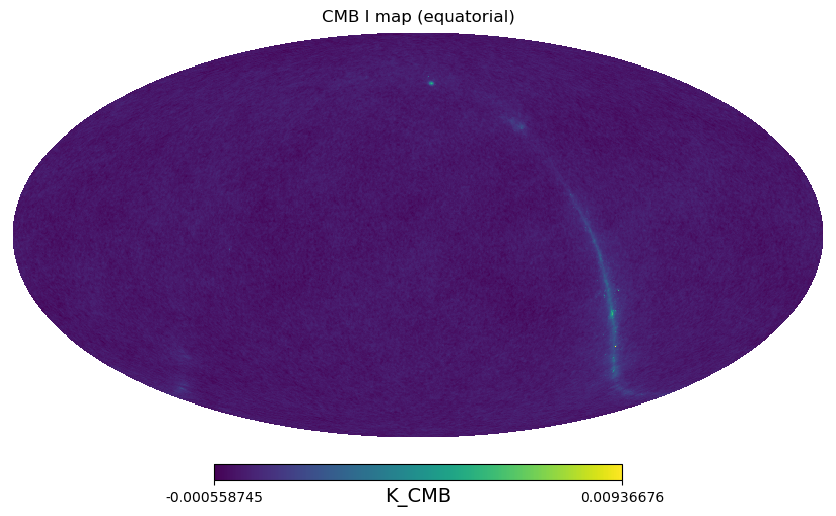

In [11]:
rGC = hp.rotator.Rotator(coord=['G','C'])  # Transforms galactic to equatorial coordinates
map_30GHz_GC = np.array([rGC.rotate_map_pixel(map) for map in map_30GHz])
hp.mollview(map_30GHz_GC[0], title="CMB I map (equatorial)", unit=map_30GHz.unit)

In [12]:
hp.write_map(filename='file_c1d0s0_30GHz.FITS',m = map_30GHz_GC, coord = 'C',overwrite=True)

setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


In [13]:
map2 = hp.read_map(filename='file_c1d0s0_30GHz.FITS',field=None)

Load a real data map from Planck

In [99]:
planck_map = hp.read_map(filename='npipe6v20_030_map.fits',field=None)

In [107]:
planck_map.shape

(3, 12582912)

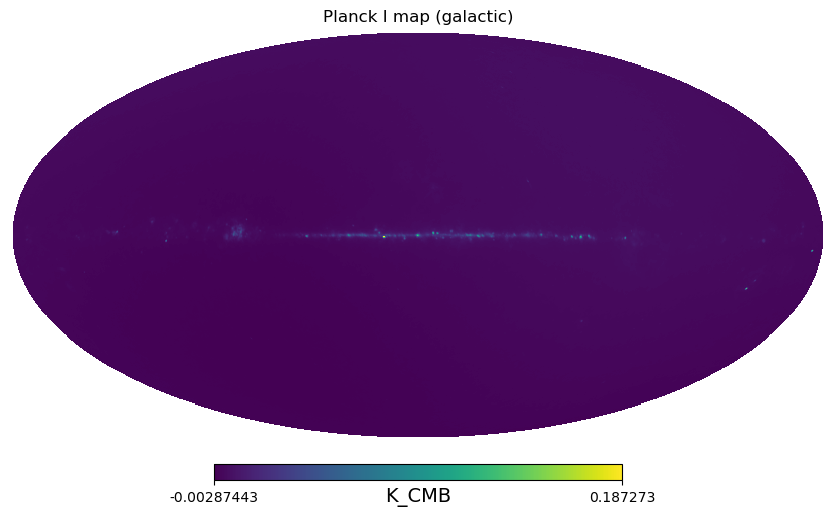

In [103]:
hp.mollview(planck_map[0], title="Planck I map (galactic)", unit=map_30GHz.unit)

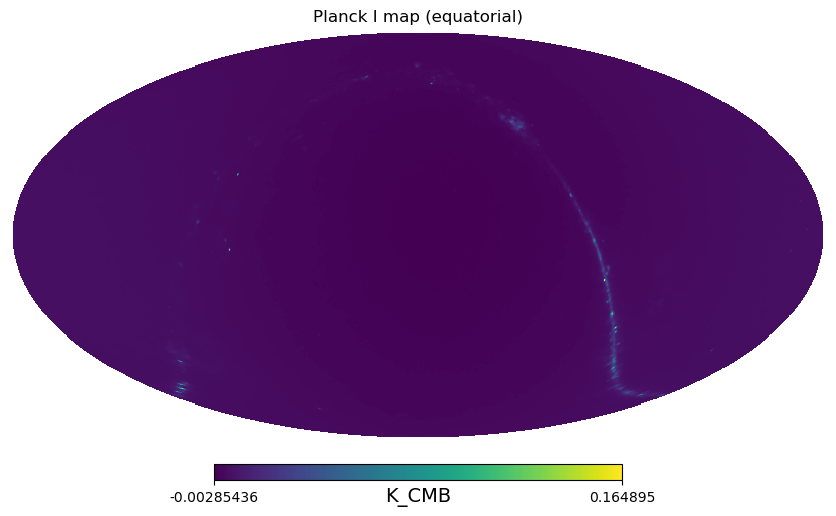

In [104]:
planck_GC = np.array([rGC.rotate_map_pixel(map) for map in planck_map])
hp.mollview(planck_GC[0], title="Planck I map (equatorial)", unit=map_30GHz.unit)

In [108]:
hp.write_map(filename='planck_030_GC.FITS',m = planck_GC, coord = 'C',overwrite=True)

setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


In [109]:
ob.detdata.create(name = 'Planck',units = u.K)
ob.detdata

<DetDataManager 252 local detectors, 50400 samples
    signal: shape=(252, 50400), dtype=float64, units='K'
    flags: shape=(252, 50400), dtype=uint8, units=''
    atmosphere: shape=(252, 50400), dtype=float64, units='K'
    noise: shape=(252, 50400), dtype=float64, units='K'
    quats: shape=(1, 50400, 4), dtype=float64, units=''
    pixels: shape=(1, 50400), dtype=int64, units=''
    weights: shape=(1, 50400, 3), dtype=float64, units=''
    contamination: shape=(252, 50400), dtype=float64, units='K'
    full: shape=(252, 50400), dtype=float64, units='K'
    temp_LHS: shape=(1, 50400), dtype=float64, units='1.0 1 / K'
    ApplyAmplitudes_temp: shape=(1, 50400), dtype=float64, units='K'
    Planck: shape=(252, 50400), dtype=float64, units='K'>

In [124]:
fwhm_spsat = 72.8

In [133]:
fwhm_planck = 35

In [134]:
planck_GC_changeresol = skytools.hpx_utils.change_resolution(map_in=planck_GC,nside_out=NSIDE,mode='iqu',fwhm_in=fwhm_planck,fwhm_out=fwhm_spsat)

In [135]:
hp.write_map(filename='planck_030_GC_512.FITS',m = planck_GC_changeresol, coord = 'C',overwrite=True)

setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


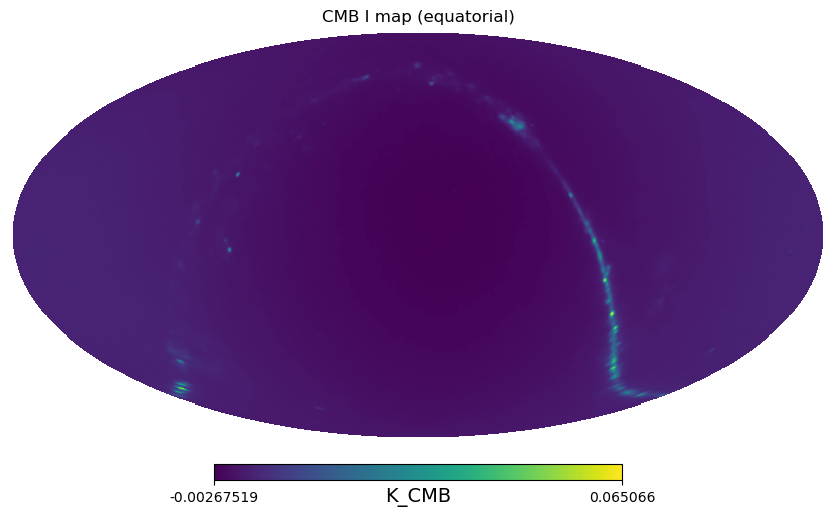

In [136]:
hp.mollview(planck_GC_changeresol[0], title="CMB I map (equatorial)", unit=map_30GHz.unit)

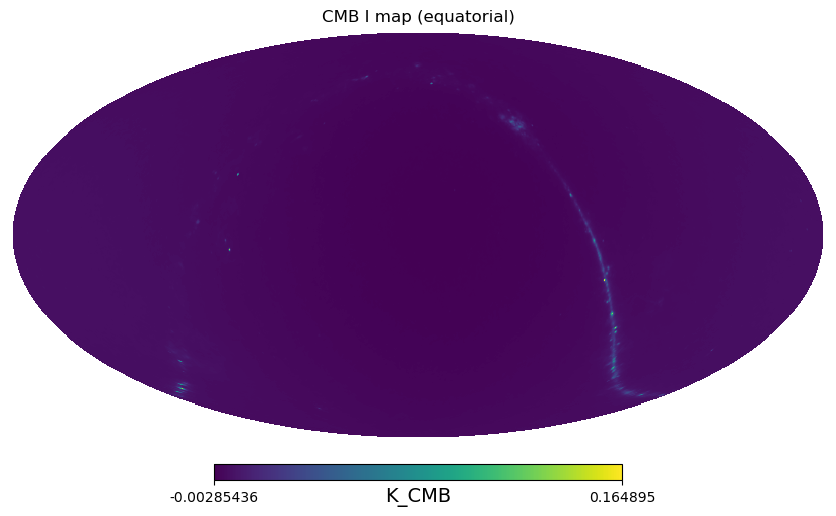

In [130]:
hp.mollview(planck_GC[0], title="CMB I map (equatorial)", unit=map_30GHz.unit)

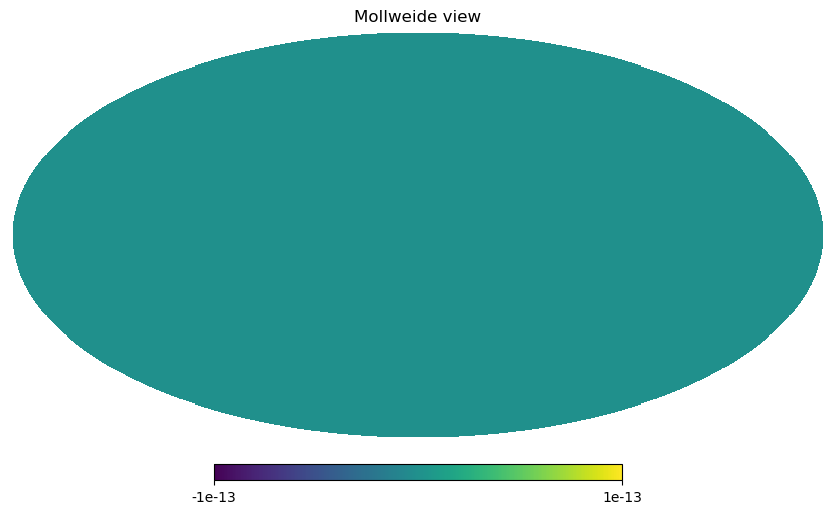

In [15]:
hp.mollview((map2-map_30GHz_GC)[0], min = -1e-13,max = 1e-13)

1. Start by creating a focalplane with a sample rate and number of detectors

In [16]:
focalplane = toast.instrument.Focalplane(sample_rate=10*u.Hz#,thinfp=256
                                        )
##One fourth of total detectors in the focalplane
## For S4, sample rate ~10-100

In [17]:
with toast.io.H5File("focalplane_SAT3_SAT_f030.h5", "r", comm=comm, force_serial=True) as f:
            focalplane.load_hdf5(f.handle, comm=comm)

Print focalplane information

In [18]:
focalplane

<Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 040_011_SAT_f030_B]>

Define the schedule, site and telescope

In [19]:
schedule = toast.schedule.GroundSchedule()
schedule.read("POLE_DEEP-169-7.txt", comm=comm)

TOAST INFO: Loading schedule from POLE_DEEP-169-7.txt
TOAST INFO: Loaded 1 scans from POLE_DEEP-169-7.txt totaling 84.0 minutes.


Print schedule information

In [20]:
schedule

<GroundSchedule site=SOUTH_POLE at -89.991 deg, -44.65 deg, 2843.0 m telescope SAT with 1 scans
  <GroundScan 'POLE_DEEP' at 2027-05-28T15:00:00+00:00 with El = 54.1 deg, Az 288.19 deg -- 358.87 deg>
>

Print telescope information

In [21]:
site = toast.instrument.GroundSite(
        schedule.site_name,
        schedule.site_lat,
        schedule.site_lon,
        schedule.site_alt,
        weather=None,
    )
telescope = toast.instrument.Telescope(
        "My_telescope", focalplane=focalplane, site=site
    )

In [22]:
telescope

<Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = None>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 040_011_SAT_f030_B]>>

We can have multiple groups for parallel computing (start with one). Create a Data Instance and simulate a ground observation operator.

In [23]:
toast_comm = toast.Comm(world=comm, groupsize=1)

In [24]:
data = toast.Data(comm=toast_comm)

In [25]:
sim_ground = toast.ops.SimGround(name="sim_ground", 
                                 weather="south_pole", 
                                 detset_key="pixel", 
                                 telescope = telescope, 
                                 schedule = schedule
                                ) ##simulate motion of the boresight

In [26]:
sim_ground

<SimGround
  API = 0 # Internal interface version for this operator
  azimuth = azimuth # Observation shared key for Azimuth
  boresight_azel = boresight_azel # Observation shared key for boresight AZ/EL
  boresight_radec = boresight_radec # Observation shared key for boresight RA/DEC
  det_data = signal # Observation detdata key to initialize
  det_data_units = K # Output units if creating detector data
  det_flags = flags # Observation detdata key for flags to initialize
  detset_key = pixel # If specified, use this column of the focalplane detector_data to group detectors
  distribute_time = False # Distribute observation data along the time axis rather than detector axis
  el_mod_amplitude = 1.0 deg # Range of elevation modulation
  el_mod_rate = 0.0 Hz # Modulate elevation continuously at this rate
  el_mod_sine = False # Modulate elevation with a sine wave instead of a triangle wave
  el_mod_step = 0.0 deg # Amount to step elevation after each left-right scan pair
  elevation = e

In [27]:
sim_ground.apply(data)

In [28]:
data.obs[0]
## Session associated to weather simulation, not individual optic tubes

<Observation
  name = 'POLE_DEEP-169-7'
  uid = '2008944542'  group has a single process (no MPI)
  telescope = <Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = <SimWeather : 'south_pole', year = 2027, month = 4, hour = 15, site UID = 588178429, realization = 0, median = False)>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 040_011_SAT_f030_B]>>
  session = <Session 'POLE_DEEP-169-7': uid = 1708650531, start = 2027-05-28 15:00:00+00:00, end = 2027-05-28 16:23:59.900000+00:00>
  scan_el = 54.1 deg
  scan_min_az = -1.2787014485740134 rad
  scan_max_az = 6.263463086632051 rad
  scan_min_el = 0.9442231253289323 rad
  scan_max_el = 0.9442231253289323 rad
  50400 total samples (50400 local)
  shared:  <SharedDataManager
    times (column): shape=(50400,), dtype=float64
    posit

In [29]:
ob = data.obs[0]

In [30]:
ob.detdata.create(name = 'atmosphere',units = u.K)
ob.detdata.create(name = 'noise',units = u.K)

In [31]:
ob.detdata

<DetDataManager 252 local detectors, 50400 samples
    signal: shape=(252, 50400), dtype=float64, units='K'
    flags: shape=(252, 50400), dtype=uint8, units=''
    atmosphere: shape=(252, 50400), dtype=float64, units='K'
    noise: shape=(252, 50400), dtype=float64, units='K'>

2. Noise simulation

In [32]:
noise_model = toast.ops.DefaultNoiseModel()
sim_noise = toast.ops.SimNoise() ###Need to instantiate Noise Model

In [33]:
sim_noise.det_data= 'noise'

In [34]:
sim_noise

<SimNoise
  API = 0 # Internal interface version for this operator
  component = 0 # The noise component index
  det_data = noise # Observation detdata key for accumulating noise timestreams
  det_data_units = K # Output units if creating detector data
  enabled = True # If True, this class instance is marked as enabled
  kernel_implementation = 0 # Which kernel implementation to use (DEFAULT, COMPILED, NUMPY, JAX).
  name = SimNoise # The 'name' of this class instance
  noise_model = noise_model # Observation key containing the noise model
  realization = 0 # The noise realization index
  serial = True # Use legacy serial implementation instead of batched
  times = times # Observation shared key for timestamps
>

In [35]:
noise_model.apply(data) ## Read detector noise from the focalplane

In [36]:
data

<Data with 1 Observations:
<Observation
  name = 'POLE_DEEP-169-7'
  uid = '2008944542'  group has a single process (no MPI)
  telescope = <Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = <SimWeather : 'south_pole', year = 2027, month = 4, hour = 15, site UID = 588178429, realization = 0, median = False)>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 040_011_SAT_f030_B]>>
  session = <Session 'POLE_DEEP-169-7': uid = 1708650531, start = 2027-05-28 15:00:00+00:00, end = 2027-05-28 16:23:59.900000+00:00>
  scan_el = 54.1 deg
  scan_min_az = -1.2787014485740134 rad
  scan_max_az = 6.263463086632051 rad
  scan_min_el = 0.9442231253289323 rad
  scan_max_el = 0.9442231253289323 rad
  noise_model = <AnalyticNoise model with 252 detectors>
  50400 total samples (50400 local)
  sha

In [37]:
sim_noise.apply(data)

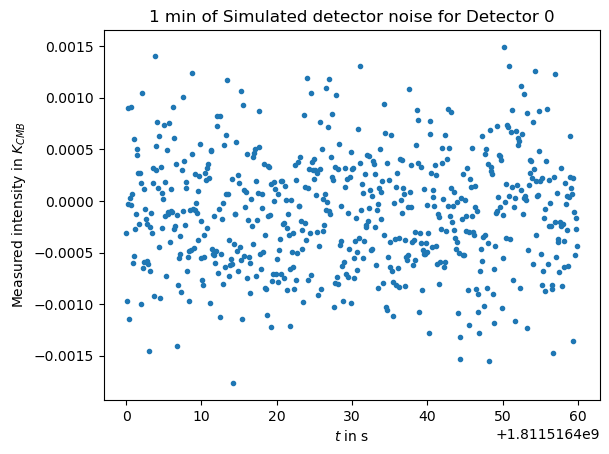

In [38]:
plt.plot(ob.shared["times"][0:600],ob.detdata["noise"][0][0:600],".") ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.xlabel('$t$ in s')
plt.ylabel('Measured intensity in $ K_{CMB}$')
plt.title('1 min of Simulated detector noise for Detector 0')
plt.show()

3. Create a pointing operator to reconstruct maps from TOD. Compute associated weights, pixelization and binning operator $\rightarrow$ mapmaking operator.

Switch from Healpix to Car?

In [39]:
pointing = toast.ops.PointingDetectorSimple() ##boresight pointing into detector frame (RA/DEC by default)
weights = toast.ops.StokesWeights(detector_pointing = pointing,mode = "IQU")
pixels = toast.ops.PixelsHealpix(detector_pointing = pointing, nside = NSIDE)

In [40]:
weights

<StokesWeights
  API = 0 # Internal interface version for this operator
  IAU = False # If True, use the IAU convention rather than COSMO
  cal = None # The observation key with a dictionary of pointing weight calibration for each det
  detector_pointing = <PointingDetectorSimple
  API = 0 # Internal interface version for this operator
  boresight = boresight_radec # Observation shared key for boresight
  coord_in = None # The input boresight coordinate system ('C', 'E', 'G')
  coord_out = None # The output coordinate system ('C', 'E', 'G')
  det_mask = 1 # Bit mask value for per-detector flagging
  enabled = True # If True, this class instance is marked as enabled
  kernel_implementation = 0 # Which kernel implementation to use (DEFAULT, COMPILED, NUMPY, JAX).
  name = PointingDetectorSimple # The 'name' of this class instance
  quats = quats # Observation detdata key for output quaternions
  shared_flag_mask = 1 # Bit mask value for optional flagging
  shared_flags = flags # Observat

In [41]:
#pixels_CAR= toast.ops.PixelsCar(detector_pointing = pointing, nside = 64)

We want to solve the map making problem using the following equations : 
\begin{equation}
    \begin{aligned}
        \mathbf{m} &= \mathbf{\left(P^T C_n ^{-1} P\right)^{-1}P^T C_n ^{-1}(y-Fa)}\\
        \mathbf{\left(F^T C_n^{-1} Z F+C_a^{-1}\right)a} &= \mathbf{F^T C_n^{-1} Zy}\\
        \text{with } \mathbf{Z} &\equiv \mathbf{I-P\left(P^T C_n ^{-1} P\right)^{-1}P^T C_n ^{-1}}
    \end{aligned}
\end{equation}

In [42]:
pointing

<PointingDetectorSimple
  API = 0 # Internal interface version for this operator
  boresight = boresight_radec # Observation shared key for boresight
  coord_in = None # The input boresight coordinate system ('C', 'E', 'G')
  coord_out = None # The output coordinate system ('C', 'E', 'G')
  det_mask = 1 # Bit mask value for per-detector flagging
  enabled = True # If True, this class instance is marked as enabled
  kernel_implementation = 0 # Which kernel implementation to use (DEFAULT, COMPILED, NUMPY, JAX).
  name = PointingDetectorSimple # The 'name' of this class instance
  quats = quats # Observation detdata key for output quaternions
  shared_flag_mask = 1 # Bit mask value for optional flagging
  shared_flags = flags # Observation shared key for telescope flags to use
  view = None # Use this view of the data in all observations
>

Choose baseline length $t_{base} \sim 1/f_{knee}$, to select modes dominant over white noise :

In [43]:
step_0 = 4*u.second
step_0

<Quantity 4. s>

In [44]:
templates = [toast.templates.Offset(name="baselines", step_time = step_0)]

In [45]:
templates

[<Offset
   data = None # This must be an instance of a Data class (or None)
   debug_plots = None # If not None, make debugging plots in this directory
   det_data = signal # Observation detdata key for the timestream data
   det_data_units = K # Desired units of detector data
   det_flag_mask = 7 # Bit mask value for solver flags
   det_flags = flags # Observation detdata key for solver flags to use
   det_mask = 1 # Bit mask value for per-detector flagging
   enabled = True # If True, this class instance is marked as enabled
   good_fraction = 0.5 # Fraction of unflagged samples needed to keep a given offset amplitude
   kernel_implementation = 0 # Which kernel implementation to use (DEFAULT, COMPILED, NUMPY, JAX).
   name = baselines # The 'name' of this class instance
   noise_model = None # Observation key containing the optional noise model
   precond_width = 20 # Preconditioner width in terms of offsets / baselines
   step_time = 4.0 s # Time per baseline step
   times = times 

In [46]:
template_matrix = toast.ops.TemplateMatrix(templates=templates)

In [47]:
template_matrix

<TemplateMatrix
  API = 0 # Internal interface version for this operator
  amplitudes = None # Data key for template amplitudes
  det_data = None # Observation detdata key for the timestream data
  det_data_units = K # Output units if creating detector data
  det_flag_mask = 7 # Bit mask value for detector sample flagging
  det_flags = flags # Observation detdata key for flags to use
  det_mask = 7 # Bit mask value for per-detector flagging
  enabled = True # If True, this class instance is marked as enabled
  kernel_implementation = 0 # Which kernel implementation to use (DEFAULT, COMPILED, NUMPY, JAX).
  name = TemplateMatrix # The 'name' of this class instance
  templates = [<Offset
  data = None # This must be an instance of a Data class (or None)
  debug_plots = None # If not None, make debugging plots in this directory
  det_data = signal # Observation detdata key for the timestream data
  det_data_units = K # Desired units of detector data
  det_flag_mask = 7 # Bit mask value fo

Create a scan operator to scan an input Healpix map : 

In [48]:
scan_map = toast.ops.ScanHealpixMap(name="scan_healpix_map", file='file_c1d0s0_30GHz.FITS',pixel_pointing = pixels, stokes_weights = weights)
scan_map.det_data = 'signal'


In [131]:
scan_planck = toast.ops.ScanHealpixMap(name="scan_healpix_input_map", file='planck_030_GC_512.FITS',pixel_pointing = pixels, stokes_weights = weights)
scan_planck.det_data = 'Planck'


In [132]:
scan_map.apply(data)
scan_planck.apply(data)
data

<Data with 1 Observations:
<Observation
  name = 'POLE_DEEP-169-7'
  uid = '2008944542'  group has a single process (no MPI)
  telescope = <Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = <SimWeather : 'south_pole', year = 2027, month = 4, hour = 15, site UID = 588178429, realization = 0, median = False)>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 040_011_SAT_f030_B]>>
  session = <Session 'POLE_DEEP-169-7': uid = 1708650531, start = 2027-05-28 15:00:00+00:00, end = 2027-05-28 16:23:59.900000+00:00>
  scan_el = 54.1 deg
  scan_min_az = -1.2787014485740134 rad
  scan_max_az = 6.263463086632051 rad
  scan_min_el = 0.9442231253289323 rad
  scan_max_el = 0.9442231253289323 rad
  noise_model = <AnalyticNoise model with 252 detectors>
  50400 total samples (50400 local)
  sha

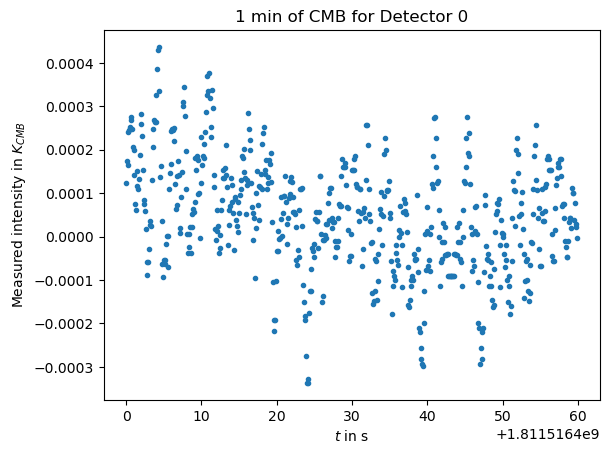

In [50]:
plt.plot(ob.shared["times"][0:600],ob.detdata["signal"][0][0:600],".") ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.xlabel('$t$ in s')
plt.ylabel('Measured intensity in $ K_{CMB}$')
plt.title('1 min of CMB for Detector 0')
plt.show()

Create horizontal pointing

In [51]:
hpointing = toast.ops.PointingDetectorSimple(boresight = 'boresight_azel')

In [52]:
hpointing

<PointingDetectorSimple
  API = 0 # Internal interface version for this operator
  boresight = boresight_azel # Observation shared key for boresight
  coord_in = None # The input boresight coordinate system ('C', 'E', 'G')
  coord_out = None # The output coordinate system ('C', 'E', 'G')
  det_mask = 1 # Bit mask value for per-detector flagging
  enabled = True # If True, this class instance is marked as enabled
  kernel_implementation = 0 # Which kernel implementation to use (DEFAULT, COMPILED, NUMPY, JAX).
  name = PointingDetectorSimple # The 'name' of this class instance
  quats = quats # Observation detdata key for output quaternions
  shared_flag_mask = 1 # Bit mask value for optional flagging
  shared_flags = flags # Observation shared key for telescope flags to use
  view = None # Use this view of the data in all observations
>

4. Atmosphere simulation

In [53]:
sim_atmosphere = toast.ops.SimAtmosphere(detector_pointing=hpointing, detector_weights= weights, det_data='atmosphere')

In [54]:
sim_atmosphere.cache_dir = 'atmosphere'

Add cache directory to save time

In [55]:
sim_atmosphere.apply(data)

In [56]:
data.obs

[<Observation
   name = 'POLE_DEEP-169-7'
   uid = '2008944542'  group has a single process (no MPI)
   telescope = <Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = <SimWeather : 'south_pole', year = 2027, month = 4, hour = 15, site UID = 588178429, realization = 0, median = False)>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 040_011_SAT_f030_B]>>
   session = <Session 'POLE_DEEP-169-7': uid = 1708650531, start = 2027-05-28 15:00:00+00:00, end = 2027-05-28 16:23:59.900000+00:00>
   scan_el = 54.1 deg
   scan_min_az = -1.2787014485740134 rad
   scan_max_az = 6.263463086632051 rad
   scan_min_el = 0.9442231253289323 rad
   scan_max_el = 0.9442231253289323 rad
   noise_model = <AnalyticNoise model with 252 detectors>
   50400 total samples (50400 local)
   shared:  <SharedD

In [57]:
data

<Data with 1 Observations:
<Observation
  name = 'POLE_DEEP-169-7'
  uid = '2008944542'  group has a single process (no MPI)
  telescope = <Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = <SimWeather : 'south_pole', year = 2027, month = 4, hour = 15, site UID = 588178429, realization = 0, median = False)>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 040_011_SAT_f030_B]>>
  session = <Session 'POLE_DEEP-169-7': uid = 1708650531, start = 2027-05-28 15:00:00+00:00, end = 2027-05-28 16:23:59.900000+00:00>
  scan_el = 54.1 deg
  scan_min_az = -1.2787014485740134 rad
  scan_max_az = 6.263463086632051 rad
  scan_min_el = 0.9442231253289323 rad
  scan_max_el = 0.9442231253289323 rad
  noise_model = <AnalyticNoise model with 252 detectors>
  50400 total samples (50400 local)
  sha

In [58]:
ob.shared["times"].shape

(50400,)

In [59]:
ob.detdata["atmosphere"].shape

(252, 50400)

In [60]:
mean_atm = np.mean(ob.detdata["atmosphere"])
print(mean_atm)

6.375452695763769


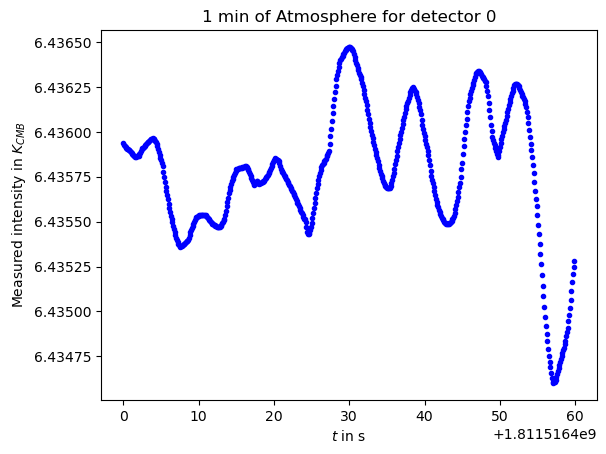

In [61]:
plt.plot(ob.shared["times"][0:600],ob.detdata["atmosphere"][0][0:600],".b") ##Detdata has several data, signal is under "signal", detdata is a 2D array

plt.xlabel('$t$ in s')
plt.ylabel('Measured intensity in $ K_{CMB}$')
plt.title('1 min of Atmosphere for detector 0')
plt.show()

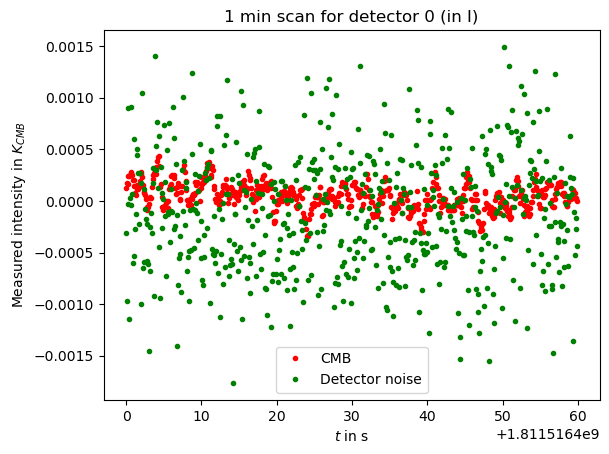

In [62]:
plt.plot(ob.shared["times"][0:600],ob.detdata["signal"][0][0:600],".r",label = 'CMB') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.plot(ob.shared["times"][0:600],ob.detdata["noise"][0][0:600],".g",label = 'Detector noise') ##Detdata has several data, signal is under "signal", detdata is a 2D array

plt.xlabel('$t$ in s')
plt.ylabel('Measured intensity in $ K_{CMB}$')
plt.legend(loc = 'best')
plt.title('1 min scan for detector 0 (in I)')
plt.show()

Add pair differences

Compute PSD to find $f_{knee}$

In [63]:
psd_detector = np.array([si.welch(TOD,fs = 10,nperseg=4096) for TOD in ob.detdata["noise"]])

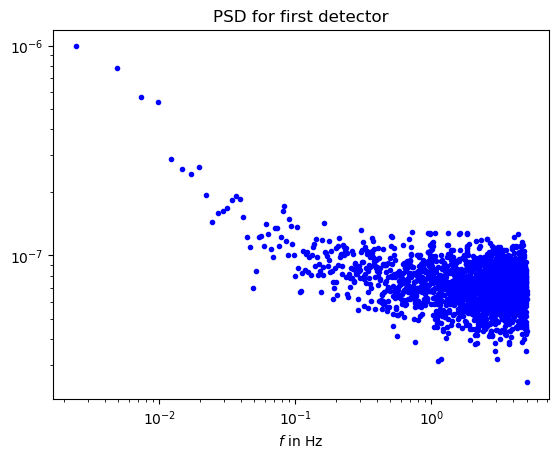

In [64]:
plt.plot(psd_detector[1,0],psd_detector[1,1],".b") ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.xscale('log')
plt.yscale('log')

plt.xlabel('$f$ in Hz')
plt.title('PSD for first detector')
plt.show()

In [65]:
ob.detdata.create(name = 'contamination',units = u.K)
ob.detdata.create(name = 'full',units = u.K)

In [66]:
type(ob.detdata['contamination'][:,:])

numpy.ndarray

In [67]:
ob.detdata['contamination'][:,:] = ob.detdata['atmosphere'][:,:]+ob.detdata['noise'][:,:]
ob.detdata['full'][:,:] = ob.detdata['contamination'][:,:]+ob.detdata['signal'][:,:]

Recombine all TOD to form the total measured timestream

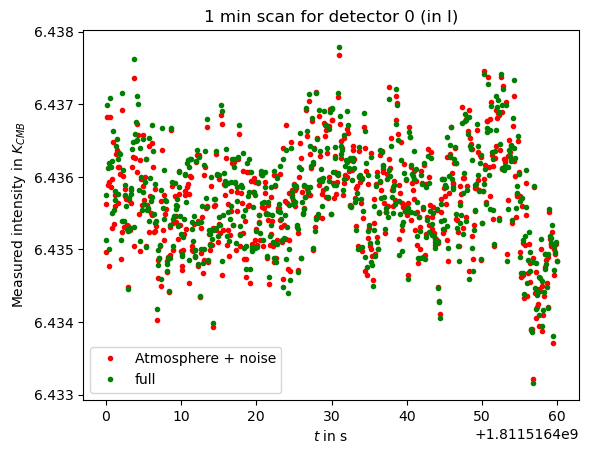

In [68]:
plt.plot(ob.shared["times"][0:600],ob.detdata["contamination"][0][0:600],".r",label = 'Atmosphere + noise') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.plot(ob.shared["times"][0:600],ob.detdata["full"][0][0:600],".g",label = 'full') ##Detdata has several data, signal is under "signal", detdata is a 2D array

plt.xlabel('$t$ in s')
plt.ylabel('Measured intensity in $ K_{CMB}$')
plt.legend(loc = 'best')
plt.title('1 min scan for detector 0 (in I)')
plt.show()

How to center data in 0? 
Find the right average?

How does the instrument adjust between detectors? Relative average level for different detectors?

Use a 0-th order polynominial filter to remove average

In [69]:
def filter_0(obs, det_data):
    obs_arr = obs.detdata[det_data]
    obs_arr2 = np.zeros(obs_arr.shape)
    i = 0
    for detec in obs_arr:
        obs_arr2[i] = detec- np.mean(detec)
        i+=1
    obs.detdata[det_data][:,:]  = obs_arr2

In [70]:
filter_0(ob,'full')

#for detdata in ["signal", "noise", "atmosphere", "contamination", "full"]:
for detdata in ["signal", "Planck"]:
    filter_0(ob,detdata)        

In [71]:
#polyfilter = toast.ops.PolyFilter(name="polyfilter1D", order=0)
#polyfilter
#
#type(ob.intervals['throw'])
#
#polyfilter.view
#
#for detdata in ["signal", "noise", "atmosphere", "contamination", "total"]:
#    polyfilter.det_data=detdata
#    polyfilter.apply(data)

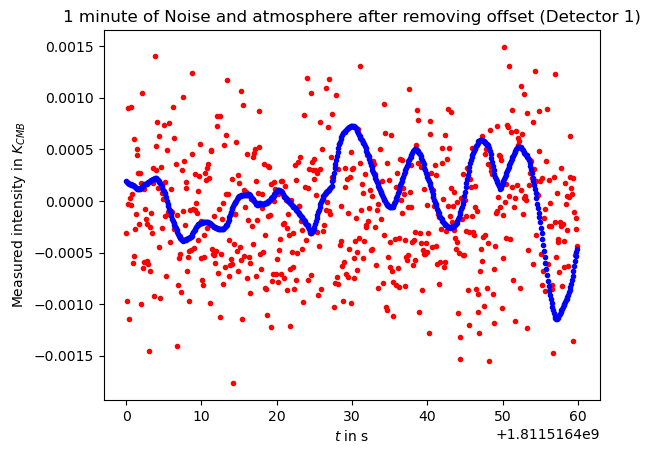

In [72]:
plt.plot(ob.shared["times"][0:600],ob.detdata["noise"][0][0:600],".r") ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.plot(ob.shared["times"][0:600],ob.detdata["atmosphere"][0][0:600],".b") ##Detdata has several data, signal is under "signal", detdata is a 2D array

plt.xlabel('$t$ in s')
plt.ylabel('Measured intensity in $ K_{CMB}$')
plt.title('1 minute of Noise and atmosphere after removing offset (Detector 1)')
plt.show()

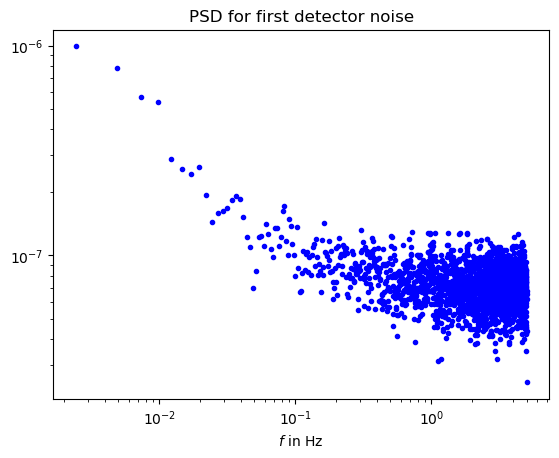

In [73]:
psd_detector = np.array([si.welch(TOD,fs = 10,nperseg=4096) for TOD in ob.detdata["noise"]])
plt.plot(psd_detector[1,0],psd_detector[1,1],".b") ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.xscale('log')
plt.yscale('log')

plt.xlabel('$f$ in Hz')
plt.title('PSD for first detector noise')
plt.show()

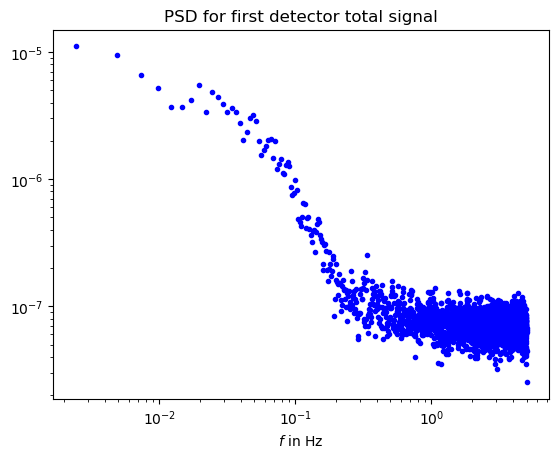

In [74]:
psd_detector = np.array([si.welch(TOD,fs = 10,nperseg=4096) for TOD in ob.detdata["full"]])
plt.plot(psd_detector[1,0],psd_detector[1,1],".b") ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.xscale('log')
plt.yscale('log')

plt.xlabel('$f$ in Hz')
plt.title('PSD for first detector total signal')
plt.show()

In [75]:
#ob.detdata['full']

<DetectorData 252 detectors each with shape (50400,), type float64, units K:
  029_000_SAT_f030_A = [ -4.581236270319351e-05 -0.000653194824772788 ... -0.0011415874095328658 -0.0009915716696642517 ]
  029_000_SAT_f030_B = [ -0.00045866033383315806 0.0011239375616910157 ... 0.00013048067557516467 -0.0008513539500577844 ]
  029_001_SAT_f030_A = [ 0.0010736191902171886 0.0013184308588263126 ... 0.0004229953299352705 0.001344777716663069 ]
  029_001_SAT_f030_B = [ -0.0006118435358235413 0.0002538734159189932 ... -2.8113853807620264e-05 0.0013089713102001472 ]
  029_002_SAT_f030_A = [ -0.0006162626759877714 0.00013022152116695725 ... 0.001421257233633872 0.0009826854794299518 ]
  029_002_SAT_f030_B = [ -0.0013700842649663203 -8.667669296535942e-05 ... 8.023263735945729e-06 0.0004894996353285165 ]
  029_003_SAT_f030_A = [ 0.0002349242784326203 0.0015328752136903726 ... 0.0011583658347630158 0.0014674502081651734 ]
  029_003_SAT_f030_B = [ -0.00010452766628932219 0.00019794063067946088 ... 0.

For each TOD, create a corresponding Mampaker operator, in order to retrieve reconstructed maps independently.

In [76]:
binner = toast.ops.BinMap(pixel_pointing = pixels, stokes_w = weights)
mapmaker = toast.ops.MapMaker(binning = binner, template_matrix=template_matrix)

In [77]:
mapmaker

<MapMaker
  API = 0 # Internal interface version for this operator
  binning = <BinMap
  API = 0 # Internal interface version for this operator
  binned = binned # The Data key where the binned map should be stored
  covariance = covariance # The Data key containing the noise covariance PixelData instance
  det_data = signal # Observation detdata key for the timestream data
  det_data_units = K # Desired timestream units
  det_flag_mask = 7 # Bit mask value for detector sample flagging
  det_flags = flags # Observation detdata key for flags to use
  det_mask = 7 # Bit mask value for per-detector flagging
  enabled = True # If True, this class instance is marked as enabled
  full_pointing = False # If True, expand pointing for all detectors and save
  kernel_implementation = 0 # Which kernel implementation to use (DEFAULT, COMPILED, NUMPY, JAX).
  name = BinMap # The 'name' of this class instance
  noise_model = noise_model # Observation key containing the noise model
  noiseweighted = 

In [78]:
mapmaker.iter_max = 50
mapmaker.convergence = 1.0e-10
mapmaker.mc_mode = False

#mapmaker

#mapmaker.mc_root = 'root'

In [79]:
mapmaker.mc_mode

False

In [80]:
binner.stokes_weights = weights

In [81]:
for detdata in ["signal", "noise", "atmosphere", "contamination", "full"]:
    binner.det_data=detdata
    mapmaker.binning= binner
    mapmaker.det_data=detdata
    mapmaker.output_dir = './'+detdata+'d0s0'
    mapmaker.apply(data)

TOAST INFO: SolveAmplitudes begin building flags for solver
TOAST INFO: SolveAmplitudes  finished flag building in 0.05 s
TOAST INFO: SolveAmplitudes begin build of solver covariance
TOAST INFO: SolveAmplitudes begin build of rcond flags
TOAST INFO: SolveAmplitudes  finished build of solver covariance in 3.52 s
TOAST INFO: SolveAmplitudes Solver flags cut 2808890 / 12700800 = 22.12% of samples
TOAST INFO: SolveAmplitudes begin RHS calculation
TOAST INFO: SolveAmplitudes  finished RHS calculation in 20.70 s
TOAST INFO: SolveAmplitudes begin PCG solver
TOAST INFO: MapMaker initial residual = 418022245368.728 in 3.79 s
TOAST INFO: MapMaker iteration    0, relative residual = 3.713153e-03 in 3.78 s
TOAST INFO: MapMaker iteration    1, relative residual = 1.629988e-03 in 3.75 s
TOAST INFO: MapMaker iteration    2, relative residual = 1.002964e-03 in 3.72 s
TOAST INFO: MapMaker iteration    3, relative residual = 5.526728e-04 in 4.51 s
TOAST INFO: MapMaker iteration    4, relative residual =

In [82]:
#for detdata in ["full"]:
#    binner.det_data=detdata
#    mapmaker.binning= binner
#    mapmaker.det_data=detdata
#    mapmaker.output_dir = './'+detdata+'d0s0'
#    mapmaker.apply(data)

#binner.det_data = 'noise'
#mapmaker_noise = toast.ops.MapMaker(binning = binner, template_matrix=template_matrix,name = 'Mapmaker_noise',iter_max = 20)
#mapmaker_noise.det_data = 'noise'
#mapmaker_noise.output_dir = './noise'
#
#mapmaker_noise.apply(data)
#
#mapmakers_dict = {}

Monte Carlo mode in MapMaker

In [83]:
#mapmakers_dict['mapmaker_noise']
#
#mapmakers_dict = {}
#
##for detdata in ["signal", "noise", "atmosphere", "contamination", "full"]:
#    binner.det_data=detdata
#    mapmakers_dict['mapmaker_'+detdata] = toast.ops.MapMaker(binning = binner, template_matrix=template_matrix,name = 'Mapmaker_'+detdata)
#    mapmakers_dict['mapmaker_'+detdata].det_data = detdata
#    mapmakers_dict['mapmaker_'+detdata].output_dir = './'+detdata+'d0s0'
#    mapmakers_dict['mapmaker_'+detdata].apply(data)
#
#mapmaker_signal
#
#binner.det_data = 'signal'
#mapmaker_signal = toast.ops.MapMaker(binning = binner, template_matrix=template_matrix,name = 'Mapmaker_signal')
#mapmaker_signal.det_data = 'signal'
##mapmaker_signal.apply(data)
#
#mapmaker_signal.apply(data)
#
#mapmaker.apply(data)
#
#mapmaker_signal.output_dir
#
#binner.det_data = 'noise'
#mapmaker_noise = toast.ops.MapMaker(binning = binner, template_matrix=template_matrix,name = 'Mapmaker_noise')
#mapmaker_noise.det_data = 'noise'
#mapmaker_noise.apply(data)
#
#binner.det_data = 'atmosphere'
#mapmaker_atmosphere = toast.ops.MapMaker(binning = binner, template_matrix=template_matrix,name = 'Mapmaker_atmosphere')
#mapmaker_atmosphere.det_data = 'atmosphere'
#mapmaker_atmosphere.apply(data)
#
#
#binner.det_data = 'contamination'
#mapmaker_contamination = toast.ops.MapMaker(binning = binner, template_matrix=template_matrix,name = 'Mapmaker_contamination')
#mapmaker_contamination.det_data = 'contamination'
#
#mapmaker_contamination.apply(data)
#
#
#binner.det_data = 'total'
#mapmaker_total = toast.ops.MapMaker(binning = binner, template_matrix=template_matrix,name = 'Mapmaker_total')
#mapmaker_total.det_data = 'total'
#
#mapmaker_total.apply(data)
#
#mapmakers_dict = {}
#
#for detdata in ["signal", "noise", "atmosphere", "contamination", "total"]:
#    binner.det_data=detdata
#    mapmakers_dict['mapmaker_'+detdata] = toast.ops.MapMaker(binning = binner, template_matrix=template_matrix,name = 'Mapmaker_'+detdata)
#    mapmakers_dict['mapmaker_'+detdata].det_data = detdata
#
#detdata = 'noise'
#binner.det_data=detdata
#mapmakers_dict['mapmaker_'+detdata] = toast.ops.MapMaker(binning = binner, template_matrix=template_matrix,name = 'Mapmaker_'+detdata)
#mapmakers_dict['mapmaker_'+detdata].det_data = detdata
#
#mapmakers_dict['mapmaker_noise']
#
#
#
#for detdata in ["signal", "noise", "atmosphere", "contamination", "total"]:
#    mapmakers_dict['mapmaker_'+detdata].apply(data)

Compare with current dc0 pipeline ie filterbin

In [84]:
filterbin = toast.ops.FilterBin(#cache_dir = 'filterbin'                                ,
                                det_flag_mask = 3 # Bit mask value for optional detector flagging
                                #,ground_filter_order=10
                                ,poly_filter_order=3
                                ,poly_filter_view = "scanning" # Intervals for polynomial filtering
                                ,rcond_threshold = 0.001 # Minimum value for inverse pixel condition number cut.
                                ,report_memory = False # Report memory throughout the execution
                                ,reset_pix_dist = False # Clear any existing pixel distribution.  Useful when applyingrepeatedly to different data objects.
                                ,rightleft_mask = 16 # Bit mask value for right-to-left scans
                                ,shared_flag_mask = 3 # Bit mask value for optional telescope flagging
                                ,shared_flags = "flags" # Observation shared key for telescope flags to use
                                ,split_ground_template = False # Apply a different template for left and right scans
                                ,write_binmap = True # If True, write the unfiltered map
                                ,write_cov = False # If True, write the white noise covariance matrices.
                                #,write_hdf5 = False # If True, output maps are in HDF5 rather than FITS format.
                                #,write_hdf5_serial = False # If True, force serial HDF5 write of output maps.
                                #,write_hits = True # If True, write the hits map
                                ,write_invcov = False # If True, write the inverse white noise covariance matrices.
                                ,write_map = True # If True, write the filtered map
                                ,write_noiseweighted_binmap = False # If True, write the noise-weighted unfiltered map
                                ,write_noiseweighted_map = False # If True, write the noise-weighted filtered map
                                ,write_obs_matrix = False # Write the observation matrix
                                ,write_rcond = False # If True, write the reciprocal condition numbers.
                                           )

In [85]:
binner.stokes_weights = weights

In [86]:
binner.stokes_weights

<StokesWeights
  API = 0 # Internal interface version for this operator
  IAU = False # If True, use the IAU convention rather than COSMO
  cal = None # The observation key with a dictionary of pointing weight calibration for each det
  detector_pointing = <PointingDetectorSimple
  API = 0 # Internal interface version for this operator
  boresight = boresight_radec # Observation shared key for boresight
  coord_in = None # The input boresight coordinate system ('C', 'E', 'G')
  coord_out = None # The output coordinate system ('C', 'E', 'G')
  det_mask = 7 # Bit mask value for per-detector flagging
  enabled = True # If True, this class instance is marked as enabled
  kernel_implementation = 0 # Which kernel implementation to use (DEFAULT, COMPILED, NUMPY, JAX).
  name = PointingDetectorSimple # The 'name' of this class instance
  quats = quats # Observation detdata key for output quaternions
  shared_flag_mask = 1 # Bit mask value for optional flagging
  shared_flags = flags # Observat

In [87]:
filterbin.det_data

'signal'

In [88]:
#for detdata in ["signal", "noise",     "atmosphere", "contamination", 
#    "full"]:
#    binner.det_data=detdata
#    filterbin.binning= binner
#    filterbin.det_data=detdata
#    filterbin.output_dir = './'+detdata+'d0s0'
#    filterbin.apply(data)

In [89]:
filterbin_dict = {}

#for detdata in ["signal", "noise", "atmosphere", "contamination", "full"]:
    binner.det_data=detdata
    filterbin_dict['filterbin_'+detdata] = toast.ops.FilterBin(#cache_dir = 'filterbin'                                ,
                                det_flag_mask = 3 # Bit mask value for optional detector flagging
                                ,ground_filter_order=10
                                ,poly_filter_order=3
                                ,poly_filter_view = "scanning" # Intervals for polynomial filtering
                                ,rcond_threshold = 0.001 # Minimum value for inverse pixel condition number cut.
                                ,report_memory = False # Report memory throughout the execution
                                ,reset_pix_dist = False # Clear any existing pixel distribution.  Useful when applyingrepeatedly to different data objects.
                                ,rightleft_mask = 16 # Bit mask value for right-to-left scans
                                ,shared_flag_mask = 3 # Bit mask value for optional telescope flagging
                                ,shared_flags = "flags" # Observation shared key for telescope flags to use
                                ,split_ground_template = False # Apply a different template for left and right scans
                                ,write_binmap = True # If True, write the unfiltered map
                                ,write_cov = False # If True, write the white noise covariance matrices.
                                #,write_hdf5 = False # If True, output maps are in HDF5 rather than FITS format.
                                #,write_hdf5_serial = False # If True, force serial HDF5 write of output maps.
                                #,write_hits = True # If True, write the hits map
                                ,write_invcov = False # If True, write the inverse white noise covariance matrices.
                                ,write_map = True # If True, write the filtered map
                                ,write_noiseweighted_binmap = False # If True, write the noise-weighted unfiltered map
                                ,write_noiseweighted_map = False # If True, write the noise-weighted filtered map
                                ,write_obs_matrix = False # Write the observation matrix
                                ,write_rcond = False # If True, write the reciprocal condition numbers.
                                ,name = 'filterbin_'+detdata
                                           )
    filterbin_dict['filterbin_'+detdata].det_data = detdata
    filterbin_dict['filterbin_'+detdata].binning= binner
    filterbin_dict['filterbin_'+detdata].output_dir = './'+detdata+'d0s0'
    filterbin_dict['filterbin_'+detdata].apply(data)
 

TOAST INFO: Binned covariance and hits in 2.55 s
TOAST INFO: Binned signal in 19.48 s
TOAST INFO: Wrote ./signald0s0/filterbin_signal_hits.fits in 0.06 s
TOAST INFO: Wrote ./signald0s0/filterbin_signal_unfiltered_map.fits in 0.28 s
TOAST WARNING:    0 : FilterBin: WARNING: template covariance matrix is poorly conditioned: rcond = 2.7877939938857913e-11.  Using matrix pseudoinverse.
TOAST INFO: FilterBin:   Filtered data in 2.45 s
TOAST INFO: Binned signal in 19.61 s
TOAST INFO: Wrote ./signald0s0/filterbin_signal_filtered_map.fits in 0.24 s
TOAST INFO: FilterBin:   Binned data in 19.85 s
TOAST INFO: Binned covariance and hits in 2.63 s
TOAST INFO: Binned signal in 18.67 s
TOAST INFO: Wrote ./noised0s0/filterbin_noise_hits.fits in 0.07 s
TOAST INFO: Wrote ./noised0s0/filterbin_noise_unfiltered_map.fits in 0.25 s
TOAST WARNING:    0 : FilterBin: WARNING: template covariance matrix is poorly conditioned: rcond = 2.7877939938857913e-11.  Using matrix pseudoinverse.
TOAST INFO: FilterBin:  

In [90]:
binner.det_data

'full'

In [91]:
filterbin.det_data

'signal'

In [92]:
os.listdir('signal')

['MapMaker_rcond.fits',
 'MapMaker_cov.fits',
 'filterbin_signal_filtered_map.fits',
 'filterbin_signal_unfiltered_map.fits',
 'filterbin_signal_hits.fits',
 'MapMaker_map.fits',
 'MapMaker_hits.fits',
 'MapMaker_binmap.fits']

In [93]:
maps = {}
#for detdata in ["signal", "noise", "atmosphere", "contamination", "full"]:
    maps['hitmap_'+detdata] = hp.read_map(detdata+"/MapMaker_hits.fits", dtype = float,field = None)
    maps['covmap_'+detdata] = hp.read_map(detdata+"/MapMaker_cov.fits", dtype = float,field = None)
    maps['map_'+detdata] = hp.read_map(detdata+"/MapMaker_map.fits", dtype = float,field = None)
    maps['binmap_'+detdata] = hp.read_map(detdata+"/MapMaker_binmap.fits", dtype = float,field = None)
    maps['rcondmap_'+detdata] = hp.read_map(detdata+"/MapMaker_rcond.fits", dtype = float,field = None)

In [94]:
maps['hitmap_signal'].shape

(49152,)

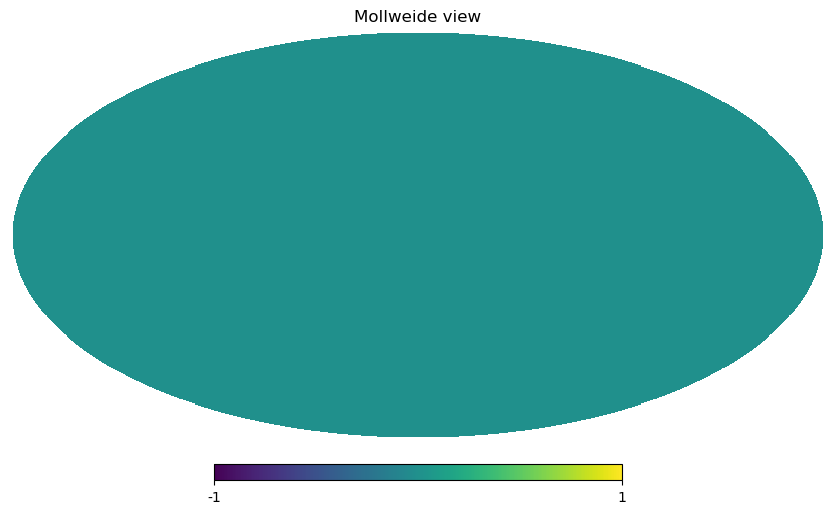

In [95]:
hp.mollview(maps['hitmap_signal']-maps['hitmap_full'])

We have retrieved 5 flavours :
1. Detector noise
2. Atmosphere
3. Sky signal (CMB)
4. Contamination (atmosphere+noise)
5. Full

and we want to check if everything has been linear

In [96]:
map_full_reconstruc = maps['map_noise']+maps['map_signal']+maps['map_atmosphere']

In [97]:
map_conta_signal = maps['map_signal']+maps['map_contamination']

In [98]:
m = maps['hitmap_signal']
diff_map = map_full_reconstruc -maps['map_full']
diff_map[m==0] = hp.UNSEEN

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3 but corresponding boolean dimension is 49152

In [ ]:
hp.mollview(diff_map, #min = -2e-7,max =7e-7, 
            title = r'$(m_{atm}+m_{noise}+m_{CMB})-m_{full}$')

In [ ]:
import numpy.linalg as lalg

rel_del = lalg.norm(map_full_reconstruc -maps['map_full'])/lalg.norm(maps['map_full'])

In [ ]:
print(rel_del)

In [ ]:
m = hp.read_map("MapMaker_hits.fits", dtype = float)
m[m==0] = hp.UNSEEN
hp.mollview(m, title =  "Hitmap")


In [ ]:
hit_mask = np.array(np.where(m<=0))[0]
mask = np.ones(m.shape,dtype = np.float64)

In [ ]:
mask.shape

In [ ]:
mask[hit_mask] = 0

In [ ]:
hp.mollview(mask, title = 'Mask associated to hits')

In [ ]:
apodized_mask = np.clip(hp.smoothing(mask, fwhm=np.radians(10)), 0, None)
hp.mollview(apodized_mask, title = 'Apodized mask')

In [ ]:
m_atm = hp.read_map("MapMaker_map.fits", dtype = float, field = None)
#m_atm -=mean_atm*mask
#m_atm[:] *= apodized_mask
#m_atm[:,hit_mask] = hp.UNSEEN

In [ ]:
m_atm.shape

In [ ]:
hp.mollview(m_atm[0], title =  "Noise + Atmosphere I map")

In [ ]:
hp.mollview(m_atm[2], title =  "Noise + Atmosphere U polarization map")

In [ ]:
hp.mollview(m_atm[1], title =  "Noise + Atmosphere Q polarization map")

In [ ]:
cls_atm = hp.anafast(m_atm, lmax=lmax,use_pixel_weights=True)

In [ ]:
cls_atm.shape

In [ ]:
l_arr = np.arange(0,lmax+1)
l_arr.shape

In [ ]:
hit_mask.shape

In [ ]:
sky_fraction = 1-(len(hit_mask) / len(mask))
print(f"The map covers {sky_fraction:.1%} of the sky")

In [ ]:
dls_atm = cls_atm[:]*l_arr*(l_arr+1)/(2*np.pi)

In [ ]:
plt.plot(l_arr, dls_atm[0]/sky_fraction,'.',label = r'$D_{\ell}^{TT}$')
plt.plot(l_arr, dls_atm[1]/sky_fraction,'.', label = r'$D_{\ell}^{EE}$')
plt.plot(l_arr, dls_atm[2]/sky_fraction,'.', label = r'$D_{\ell}^{BB}$')
plt.xlabel('$\ell$')
plt.ylabel('$\mu K_{CMB}^2$')
plt.legend(loc = 'best')
plt.xscale('log')
plt.yscale('log')
plt.title('Noise + atmosphere')
plt.show()